<h1>Reiknum Kernel MNIST gagna</h1>

In [6]:
using MLDatasets, Flux, LinearAlgebra, ProgressMeter
include("DenseNTK.jl"); include("FastNTK.jl")

function load_MNIST()
    """
    Loading the MNIST dataset.
    10 classes of digits from 0 to 9,
    each with 28x28 pixel dimensions.
    X: Grayscale vector, Y: Correct label.
    """

    X_training, Y_training = MNIST(split = :train)[:]
    X_testing, Y_testing = MNIST(split = :test)[:]
    X_training = Flux.flatten(X_training)
    X_testing = Flux.flatten(X_testing)
    Y_training = Flux.onehotbatch(Y_training, 0:9)
    Y_testing = Flux.onehotbatch(Y_testing, 0:9)
    return X_training, Y_training, X_testing, Y_testing
end

load_MNIST (generic function with 1 method)

In [7]:
# Model frá https://towardsdatascience.com/flux-jl-on-mnist-variations-of-a-theme-c3cd7a949f8c

model4LS = Chain(
  Dense(28 * 28, 16, sigmoid),        # 784 x 16 + 16 = 12560 parameters
  Dense(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  Dense(16, 16, sigmoid),             #  16 x 16 + 16 =   272 parameters
  Dense(16, 10, sigmoid)              #  16 x 10 + 10 =   170 parameters
)                                     #             --> 13274 parameters total

model3LS = Chain(
  Dense(28 * 28, 60, sigmoid),        # 784 x 60 + 60 = 47100 parameters
  Dense(60, 60, sigmoid),             #  60 x 60 + 60 =  3660 parameters
  Dense(60, 10, sigmoid)              #  60 x 10 + 10 =   610 parameters
)                                     #             --> 51370 parameters total

model2LR = Chain(
  Dense(28 * 28, 32, relu),           # 784 x 32 + 32 = 25120 parameters
  Dense(32, 10),                      #  32 x 10 + 10 =   330 parameters
  softmax                             #             --> 25450 parameters total
)

Chain(
  Dense(784 => 32, relu),               # 25_120 parameters
  Dense(32 => 10),                      # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.664 KiB.

In [51]:
N=5_000
x = load_MNIST()[1][:,1:N];

eig_fix(K) = abs.(eigen(K).values)+ones(length(eigen(K).values))*1e-26;

In [50]:
K4LS = kernel(model4LS, x, true)
K3LS = kernel(model3LS, x, true)
K2LR = kernel(model2LR, x, true)

OutOfMemoryError: OutOfMemoryError()

In [43]:
eig1 = eig_fix(K3LS)
eig2 = eig_fix(K2LR)
eig3 = eig_fix(K4LS)

2000-element Vector{Float64}:
 1.0e-26
 1.0e-26
 1.0e-26
 1.0e-26
 1.0e-26
 1.0e-26
 1.0e-26
 1.0e-26
 1.0e-26
 1.0e-26
 ⋮
 5.063228118317131
 5.462318502938788
 5.775748123850748
 6.51304534690021
 6.709957621006975
 6.817531451451672
 7.084681317687853
 7.194453479063044
 7.394593614883986

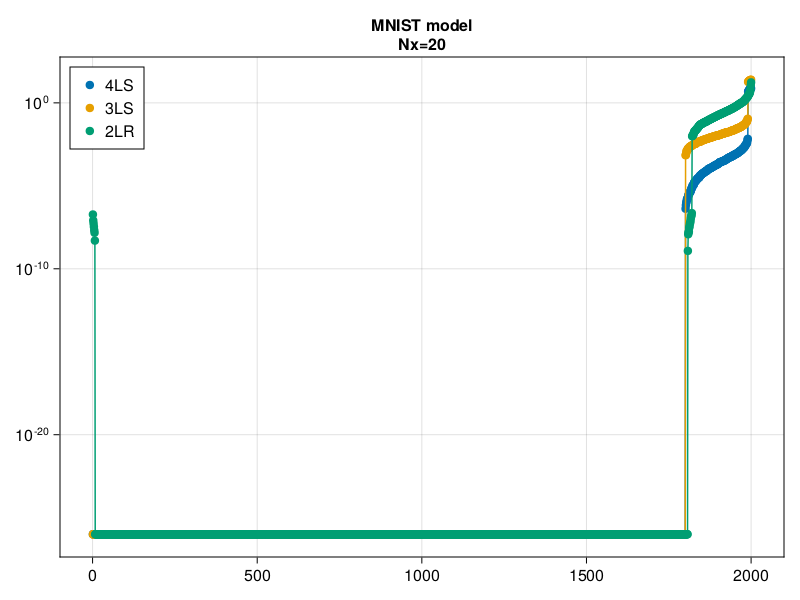

In [44]:
using CairoMakie

fig = Figure()
ax1 = Axis(fig[1,1], yscale=log10, title="MNIST model\nNx=$N")

CairoMakie.scatter!(eig3, label="4LS")
CairoMakie.lines!(eig3)

CairoMakie.scatter!(eig1, label="3LS")
CairoMakie.lines!(eig1)

CairoMakie.scatter!(eig2, label="2LR")
CairoMakie.lines!(eig2)

axislegend(ax1,position=:lt)
fig